# Read Me
**How to run this code:**<br>
Running this code is basically like running any iPython notebook, and then basically you run the cell sequentially.

**Implimentation and architecture details:**<br>
1. I imported MobileNetV3 small model from torchvision.models and then I changed the last layer to 9 classes.<br>
2. **Number of Epochs**: I trained for multiple epochs and then I found that the validation accuracy was not increasing after 15 epochs, so I stopped the training at 15 epochs.<br>
3. I would also save my Model only if the validation accuracy imporves in that epoch.
4. I implemented Automatic Mixed Precision to speed up the training
5. **LR Scheduler**: I implimented Reduce LR on Plateau and Cosine Annealing LR and I found that Cosine Annealing LR gave me better results.
6. **Optimizer**: I tried SGD optimizer, which gave good results, but I found that AdamW optimizer gave me better results.
7. **Architecture**: I experimented with ConvNeXt and Mobilenet V3 small and I found that both gave me similar results.
8. **Hyper Parameters**: I experimented with several hyper parameters but the hyper parameters that gave met the best accauracy are the ones that are implimented in this notebook below
9. **Data Augmentation**: I experimented with Gaussian Blur and Color Jitter for brightness becasue thats in the write up it was mentioned that, thats how the test imaged might be different from the training images.
10. I used Image Folder Dataset to load the data and I used 80% of the data for training and 20% for validation, and wrote a custom dataset class to load the test data.
11. **Loss Function**: I used Cross Entropy Loss as the loss function because it is a multi class classification problem.
12. I was able to get 94.7654% validation accuracy which was the same as mobile net v3 small model oddly enough.
13. I also ensemble ConvNeXt and MobileNetV3 small model and I got 94.8148% validation accuracy which was very slighltly better than individual models.

In [ ]:
# !unzip ML\ Assessment\ Data.zip

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as ttf

import os
import os.path as osp

from tqdm import tqdm
from PIL import Image
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Hyperparameters

In [2]:

batch_size = 128
lr = 0.001
epochs = 15 

# ConvNeXt Block and Model Architecture Class Definition

In [3]:
#Block class for ConvNext 
class Block(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        '''
        in_channels: number of input channels
        '''
        #depthwise convolution
        self.dwconv = nn.Conv2d(in_channels, in_channels, kernel_size=7, padding=3, groups=in_channels)
        self.bn = nn.BatchNorm2d(in_channels)
        #point wise convolution
        self.pwconv1 = nn.Conv2d(in_channels, 4 * in_channels, kernel_size=1, stride=1)
        self.act = nn.GELU()
        self.pwconv2 = nn.Conv2d(4 * in_channels, in_channels, kernel_size=1, stride=1)


    def forward(self, x):
        '''
        x: input tensor
        return: output tensor
        '''
        input = x
        out = self.dwconv(x)
        out = self.bn(out)
        out = self.pwconv1(out)
        out = self.act(out)
        out = self.pwconv2(out)
        out = input + out
        return out

In [4]:
#ConvNext class
class ConvNext(nn.Module):
    def __init__(self, in_channels, num_classes = 7000, depths = [3, 3, 9, 3], dims = [96, 192, 384, 758]):
        super().__init__()
        '''
        in_channels: number of input channels
        num_classes: number of classes
        depths: number of blocks in each down sample layer
        dims: number of channels in each down sample layer
        '''
        self.down_sample_layers = nn.ModuleList()
        stem = nn.Sequential(nn.Conv2d(in_channels, dims[0], kernel_size=4, stride=4),
                                nn.BatchNorm2d(dims[0])
                                )
        self.down_sample_layers.append(stem)
        #3 down sample layers
        for i in range(3):
            downsample_layer = nn.Sequential(
                nn.BatchNorm2d(dims[i]),
                nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2))
            self.down_sample_layers.append(downsample_layer)
            
        self.block_layers = nn.ModuleList()
        #4 stages of blocks
        for i in range(4):
            blocks = nn.ModuleList()
            # blocks = []
            for j in range(depths[i]):
                block = Block(dims[i])
                blocks.append(block)
            self.block_layers.append(nn.Sequential(*blocks))
        #1 final layer classification layer
        self.norm = nn.BatchNorm2d(dims[-1])
        self.classifier = nn.Linear(dims[-1], num_classes)

    def forward(self, x):
        '''
        x: input tensor
        return: output tensor
        '''
        #4 down sample layers
        for i in range(4):
            x = self.down_sample_layers[i](x)
            x = self.block_layers[i](x) 
        #finall layer
        x = self.norm(x)
        x = F.adaptive_avg_pool2d(x, 1)
        feats = x.view(x.size(0), -1)
        x = self.classifier(feats)
        return x
    

# Dataset & DataLoader

In [5]:
# Data directory 
TRAIN_DIR = 'train/'
VAL_DIR = 'val/'
TEST_DIR = 'test/'

# Data augmentation for training
train_transforms = [
        ttf.ColorJitter(brightness=(0.5, 1.5)),
        # ttf.GaussianBlur(7, sigma=(0.1, 2.0)),
        ttf.Resize((500, 600)),
        ttf.CenterCrop(300),
        ttf.ToTensor(),  # Finally converts PIL image to tensor so we can train w. pytorch

        ]

# Data augmentation for validation
val_transforms = [
                ttf.Resize((500, 600)),
                ttf.CenterCrop(300),
                ttf.ToTensor()]

# Dataset class for training and validation
train_dataset = torchvision.datasets.ImageFolder(TRAIN_DIR,
                                                 transform=ttf.Compose(train_transforms))
val_dataset = torchvision.datasets.ImageFolder(VAL_DIR,
                                               transform=ttf.Compose(val_transforms))

# Dataloader for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        drop_last=True, num_workers=4, pin_memory=True)

{0: '2.0 mm x26 mm', 1: '2.0 mm x28 mm', 2: '2.8 mm x22 mm', 3: '3.5 mm x19 mm', 4: '3.5 mm x22 mm', 5: '3.5 mm x28 mm', 6: '3.5 mm x30 mm', 7: '4.2 mm x22 mm', 8: '4.2 mm x30 mm'}
Class name:  2.0 mm x26 mm


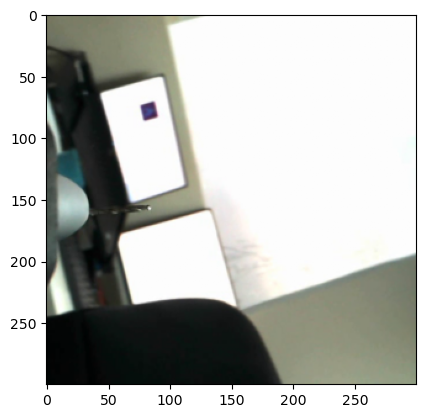

In [6]:
# dataset to class names
class_to_idx = train_dataset.class_to_idx
# index to class names mapping
idx_to_class = {v: k[0]+'.'+ k[1] + ' mm ' + k[2:]+ ' mm'for k, v in class_to_idx.items()}
print(idx_to_class)
numb_classes = len(train_dataset.classes)

# display some images
def imshow(img):
    '''
    Display an image
    img: tensor image
    '''
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# print some random training images
for img, label in val_loader:
    label = label[0]
    # map label to class name
    print('Class name: ', idx_to_class[label.item()])
    imshow(img[0])
    break


In [16]:
# draw a bar chart of the number of images per class
def draw_bar_chart(dataset):
    '''
    Draw a bar chart of the number of images per class
    dataset: dataset
    '''
    class_count = [0] * len(dataset.classes)
    for _, label in dataset:
        class_count[label] += 1
    plt.bar(range(len(dataset.classes)), class_count)
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.show()

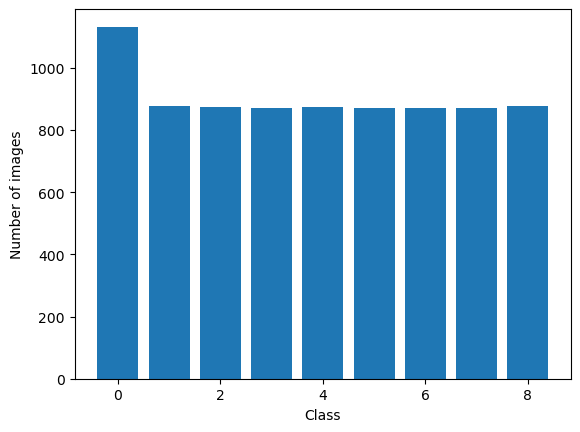

In [17]:
# draw bar chart for training dataset
draw_bar_chart(train_dataset)

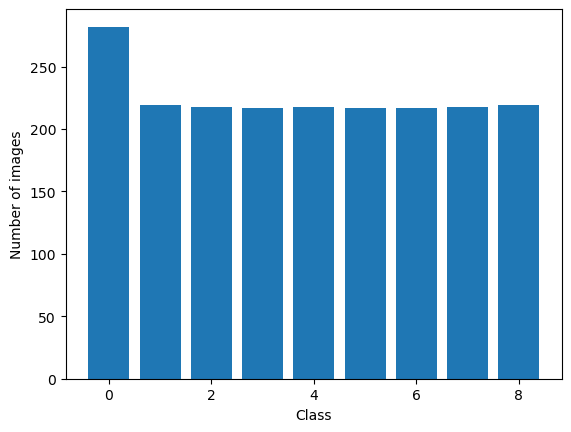

In [18]:
# draw bar chart for validation dataset
draw_bar_chart(val_dataset)

# Setup everything for training

In [7]:
# model definition
convnext = ConvNext(3, num_classes = numb_classes, depths = [3, 3, 9, 3], dims = [96, 192, 384, 758])
convnext.to(device)

# define loss function and optimizer and scheduler for training
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
optimizer = optim.AdamW(convnext.parameters(), lr=lr, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(len(train_loader) * epochs))
scaler = torch.cuda.amp.GradScaler()

from torchsummary import summary
print(summary(convnext, (3, 300, 300)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 75, 75]           4,704
       BatchNorm2d-2           [-1, 96, 75, 75]             192
            Conv2d-3           [-1, 96, 75, 75]           4,800
       BatchNorm2d-4           [-1, 96, 75, 75]             192
            Conv2d-5          [-1, 384, 75, 75]          37,248
              GELU-6          [-1, 384, 75, 75]               0
            Conv2d-7           [-1, 96, 75, 75]          36,960
             Block-8           [-1, 96, 75, 75]               0
            Conv2d-9           [-1, 96, 75, 75]           4,800
      BatchNorm2d-10           [-1, 96, 75, 75]             192
           Conv2d-11          [-1, 384, 75, 75]          37,248
             GELU-12          [-1, 384, 75, 75]               0
           Conv2d-13           [-1, 96, 75, 75]          36,960
            Block-14           [-1, 96,

# Let's train!

In [8]:
# initialize lists to store training and validation loss and accuracy
val_max = 0

In [9]:
# parameters to keep track of training
train_losses = []
val_losses = []
train_accs = []
val_accs = []

In [10]:
# Training loop
for epoch in tqdm(range(epochs)):
    convnext.train()
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train') 

    # initialize variables to store training loss and accuracy
    num_correct = 0
    total_loss = 0

    for i, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()

        x = x.cuda()
        y = y.cuda()

        # Mixed precision training for faster training
        with torch.cuda.amp.autocast():     
            outputs = convnext(x)
            loss = criterion(outputs, y)

        # Update # correct & loss as we go
        num_correct += int((torch.argmax(outputs, axis=1) == y).sum())
        total_loss += float(loss)

        train_acc = 100 * num_correct / ((i + 1) * batch_size)
        train_loss = float(total_loss / (i + 1))
        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc="{:.04f}%".format(train_acc),
            loss="{:.04f}".format(train_loss),
            num_correct=num_correct,
            lr="{:.16f}".format(float(optimizer.param_groups[0]['lr'])))
        
        # Backprop and update weights with mixed precision
        scaler.scale(loss).backward() # This is a replacement for loss.backward() with mixed precision
        scaler.step(optimizer) # This is a replacement for optimizer.step() with mixed precision
        scaler.update() # This is something added just for FP16 support, for mixed precision training

        scheduler.step() # We told scheduler T_max that we'd call step() (len(train_loader) * epochs) many times.

        batch_bar.update() # Update tqdm bar
    batch_bar.close() # need this to close the tqdm bar

    # Print some metrics
    train_acc = 100 * num_correct / (len(train_loader) * batch_size)
    train_loss = float(total_loss / len(train_loader))
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    print("Epoch {}/{}: Train Acc {:.04f}%, Train Loss {:.04f}, Learning Rate {:.16f}".format(
        epoch + 1,
        epochs,
        train_acc,
        train_loss,
        float(optimizer.param_groups[0]['lr'])))


    # Validation loop
    convnext.eval()
    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')
    num_correct = 0
    total_val_loss = 0
    for i, (x, y) in enumerate(val_loader):

        x = x.cuda()
        y = y.cuda()

        with torch.no_grad():
          with torch.cuda.amp.autocast(): 
            outputs = convnext(x)
            valid_loss = criterion(outputs, y)

        num_correct += int((torch.argmax(outputs, axis=1) == y).sum())
        total_val_loss += float(valid_loss)
        
        batch_bar.set_postfix(acc="{:.04f}%".format(100 * num_correct / ((i + 1) * batch_size)))
        batch_bar.update()
    batch_bar.close()
    val = 100 * num_correct / len(val_dataset)
    val_loss = float(total_val_loss / len(val_loader))
    val_losses.append(val_loss)
    val_accs.append(val)
    print("Validation Accuracy: {:.04f}%".format(val), 'Validation Loss: {:.04f}'.format(val_loss))

    if val > val_max:
      val_max = val
      f_name = 'convnext.pt'
      print('Saving model with validation accuracy {:.04f}%'.format(val))
      torch.save(convnext, f_name)


Epoch 1/15: Train Acc 18.7996%, Train Loss 2.2354, Learning Rate 0.0009890738003669


Validation Accuracy: 24.4938% Validation Loss: 2.0855
Saving model with validation accuracy 24.4938%


Epoch 2/15: Train Acc 34.3750%, Train Loss 1.9358, Learning Rate 0.0009567727288213


Validation Accuracy: 38.9136% Validation Loss: 1.8503
Saving model with validation accuracy 38.9136%


Epoch 3/15: Train Acc 57.0437%, Train Loss 1.5983, Learning Rate 0.0009045084971875


Validation Accuracy: 52.9383% Validation Loss: 1.6473
Saving model with validation accuracy 52.9383%


Epoch 4/15: Train Acc 79.8611%, Train Loss 1.2687, Learning Rate 0.0008345653031794


Validation Accuracy: 73.2840% Validation Loss: 1.3053
Saving model with validation accuracy 73.2840%


Epoch 5/15: Train Acc 92.4727%, Train Loss 1.0779, Learning Rate 0.0007500000000000


Validation Accuracy: 91.4568% Validation Loss: 1.0156
Saving model with validation accuracy 91.4568%


Epoch 6/15: Train Acc 98.3383%, Train Loss 0.9491, Learning Rate 0.0006545084971875


Validation Accuracy: 94.1235% Validation Loss: 0.9218
Saving model with validation accuracy 94.1235%


Epoch 7/15: Train Acc 99.6032%, Train Loss 0.9016, Learning Rate 0.0005522642316338


 47%|████▋     | 7/15 [26:39<30:01, 225.16s/it]                   

Validation Accuracy: 94.1235% Validation Loss: 0.9043


Epoch 8/15: Train Acc 99.9380%, Train Loss 0.8766, Learning Rate 0.0004477357683662


Validation Accuracy: 94.6173% Validation Loss: 0.8761
Saving model with validation accuracy 94.6173%


Epoch 9/15: Train Acc 99.9876%, Train Loss 0.8658, Learning Rate 0.0003454915028125


Validation Accuracy: 94.7160% Validation Loss: 0.8659
Saving model with validation accuracy 94.7160%


Epoch 10/15: Train Acc 100.0000%, Train Loss 0.8593, Learning Rate 0.0002500000000000


 67%|██████▋   | 10/15 [37:50<18:40, 224.03s/it]                   

Validation Accuracy: 94.7160% Validation Loss: 0.8602


Epoch 11/15: Train Acc 100.0000%, Train Loss 0.8545, Learning Rate 0.0001654346968206


 73%|███████▎  | 11/15 [41:34<14:55, 223.84s/it]                   

Validation Accuracy: 94.7160% Validation Loss: 0.8579


Epoch 12/15: Train Acc 100.0000%, Train Loss 0.8522, Learning Rate 0.0000954915028125


Validation Accuracy: 94.7654% Validation Loss: 0.8536
Saving model with validation accuracy 94.7654%


Epoch 13/15: Train Acc 100.0000%, Train Loss 0.8506, Learning Rate 0.0000432272711787


 87%|████████▋ | 13/15 [49:00<07:26, 223.46s/it]                   

Validation Accuracy: 94.7160% Validation Loss: 0.8528


Epoch 14/15: Train Acc 100.0000%, Train Loss 0.8498, Learning Rate 0.0000109261996331


 93%|█████████▎| 14/15 [52:44<03:43, 223.47s/it]                   

Validation Accuracy: 94.7160% Validation Loss: 0.8525


Epoch 15/15: Train Acc 100.0000%, Train Loss 0.8493, Learning Rate 0.0000000000000000


100%|██████████| 15/15 [56:27<00:00, 225.82s/it]                   

Validation Accuracy: 94.7160% Validation Loss: 0.8522


# Plot the training and validation loss

Text(0.5, 1.0, 'Loss vs Epoch')

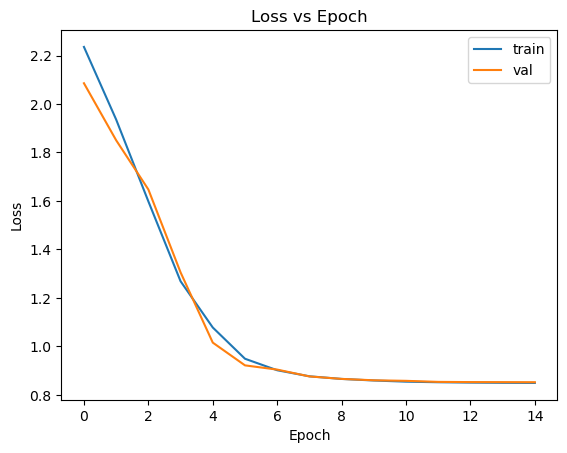

In [11]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')

# Plot the training and validation accuracy

Text(0.5, 1.0, 'Accuracy vs Epoch')

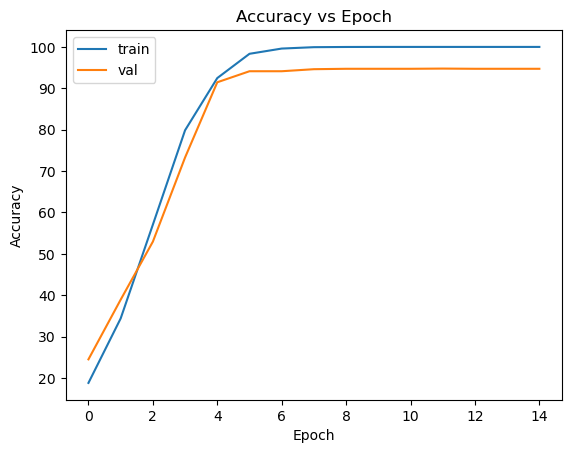

In [12]:
plt.plot(train_accs, label='train')
plt.plot(val_accs, label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')

# Classification Task: Validation

In [64]:
convnext.load_state_dict(torch.load('convnext.pt', map_location=torch.device(device=device)).state_dict())

<All keys matched successfully>

In [14]:
convnext.eval()
batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')
num_correct = 0
for i, (x, y) in enumerate(val_loader):

    x = x.cuda()
    y = y.cuda()

    with torch.no_grad():
      with torch.cuda.amp.autocast():
        outputs = convnext(x)

    num_correct += int((torch.argmax(outputs, axis=1) == y).sum())
    batch_bar.set_postfix(acc="{:.04f}%".format(100 * num_correct / ((i + 1) * batch_size)))

    batch_bar.update()
    
batch_bar.close()
print("Validation Accuracy: {:.04f}%".format(100 * num_correct / len(val_dataset)))

Validation Accuracy: 94.7654%


# Classification Task: Test

In [25]:
class ClassificationTestSet(Dataset):
    # It's possible to load test set data using ImageFolder without making a custom class.
    # See if you can think it through!

    def __init__(self, data_dir, transforms):
        ''''
        Args:
            data_dir: Path to the directory containing the test set images
            transforms: PyTorch transforms to apply to the images
        '''
        self.data_dir = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in data_dir
        self.img_paths = list(map(lambda fname: osp.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        return self.transforms(Image.open(self.img_paths[idx])), self.img_paths[idx].split('/')[-1]

In [26]:
# Test dataset and dataloader classes
test_dataset = ClassificationTestSet(TEST_DIR, ttf.Compose(val_transforms))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         drop_last=False, num_workers=4, pin_memory=True)
print('Test set size:', len(test_dataset))

Test set size: 2025


In [55]:
convnext.eval()
batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, position=0, leave=False, desc='Test')

res = []
for x, file_name in test_loader:

    x = x.cuda()
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            outputs = convnext(x)
        y_hat = torch.argmax(outputs, axis=1)
        res.extend(list(zip(file_name, y_hat.cpu().numpy())))
    
    batch_bar.update()
    
batch_bar.close()

In [56]:
# map the labels to the classes
res = list(map(lambda x: (x[0], idx_to_class[x[1]]), res))
print('Length of test set predictions:', len(res))

Length of test set predictions: 2025


In [57]:
# convert to a dataframe and print the file name and the predicted class
df = pd.DataFrame(res, columns=['file_name', 'predicted_class'])
print(df)

           file_name predicted_class
0     frame10002.png   3.5 mm x22 mm
1     frame10006.png   3.5 mm x22 mm
2     frame10014.png   3.5 mm x22 mm
3     frame10016.png   3.5 mm x22 mm
4     frame10022.png   3.5 mm x22 mm
...              ...             ...
2020   frame9976.png   3.5 mm x22 mm
2021   frame9980.png   3.5 mm x22 mm
2022   frame9992.png   3.5 mm x22 mm
2023   frame9996.png   3.5 mm x22 mm
2024   frame9998.png   3.5 mm x22 mm

[2025 rows x 2 columns]


In [58]:
#print the number of images in each class
print('Predicted class:', 'Number of images')
print(df['predicted_class'].value_counts())

Predicted class: Number of images
2.0 mm x26 mm    282
4.2 mm x30 mm    219
2.0 mm x28 mm    219
3.5 mm x22 mm    218
3.5 mm x19 mm    218
4.2 mm x22 mm    218
2.8 mm x22 mm    218
3.5 mm x30 mm    217
3.5 mm x28 mm    216
Name: predicted_class, dtype: int64


<AxesSubplot:>

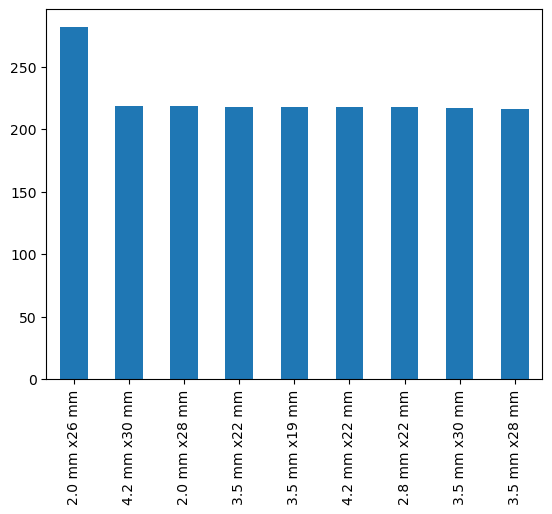

In [59]:
#plot the number of images in each class
df['predicted_class'].value_counts().plot(kind='bar')

# Discussion
This distribution looks very similar to the distribution of the training data and the validation data from which the test data was sampled. This means that the model is and rest of the system is working as expected.

In [60]:
# save the dataframe to a csv file
df.to_csv('convnext_predictions.csv', index=False)

# MobileNetV3 and ConvNeXt Ensemble

In [61]:
mobilenet = torchvision.models.mobilenet_v3_small(weights='IMAGENET1K_V1')
mobilenet.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(576, numb_classes)
)

In [62]:
convnext.load_state_dict(torch.load('convnext.pt', map_location=torch.device(device=device)).state_dict())
mobilenet.load_state_dict(torch.load('mobilenet.pt', map_location=torch.device(device=device)).state_dict())

<All keys matched successfully>

In [67]:
mobilenet.to(device)
convnext.to(device)
print('Model loaded')

Model loaded


In [73]:
mobilenet.eval()
convnext.eval()
batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')
num_correct = 0
for i, (x, y) in enumerate(val_loader):

    x = x.to(device)
    y = y.to(device)

    with torch.no_grad():
      with torch.cuda.amp.autocast():
        outputs = mobilenet(x) + convnext(x) 

    num_correct += int((torch.argmax(outputs, axis=1) == y).sum())
    batch_bar.set_postfix(acc="{:.04f}%".format(100 * num_correct / ((i + 1) * batch_size)))

    batch_bar.update()
    
batch_bar.close()
print("Validation Accuracy: {:.04f}%".format(100 * num_correct / len(val_dataset)))

Validation Accuracy: 94.8148%
